In this file I start working on the ideas around the embeddings API. Our main ideas are
1. We want to do classifications directly from the embeddings, that should be equivalent to classification without chain-of-thought
2. We want to understand what GPT learns from the data doing some test on classifying different things
3. We want to explore clustering
4. All of these things may yield different results depending on whether we embedd only the description or an entire prompt (potentially including examples)

In [1]:
# imports
import openai
import sys
import pandas as pd
sys.path.append('../99-other-project')
from gptClassifier2 import standard_message
# insert your api key

In [2]:
openai.api_key = ""

##### checking token length

In [7]:
with open('text.txt') as f:
    lines = f.readlines()
    f.close()

In [10]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(str(lines), "cl100k_base")

7316

##### Obtain embeddings

In [6]:
text = str(standard_message)
def get_embedding(text, model="text-embedding-ada-002"):
   #text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [31]:
embedding = get_embedding(text)
#embedding2 = get_embedding("hello\nwhat's up")
len(embedding)

1536

In [36]:
import pandas as pd
pd.DataFrame([embedding2["data"][0]["embedding"],embedding["data"][0]["embedding"]]).transpose()

,0,1
0,-0.015173,-0.021946
1,0.000535,0.021645
2,-0.008569,-0.008355
3,-0.030584,-0.019528
4,-0.017442,-0.038169
...,...,...
1531,0.012962,0.001020
1532,-0.007148,0.011566
1533,-0.031965,-0.019556
1534,0.009889,0.002831


In [16]:
sys.path.append('../7-Self-Labelled-Data/data/')
df = pd.read_pickle("../7-Self-Labelled-Data/annotated_val_explantions_gpt3.pkl")

In [25]:
# takes 6-7 minutes for 1200 samples
embeddings_val = []
for caption in df["caption"]:
    embeddings_val.append(get_embedding(caption))

In [ ]:
# OPTIONAL alternative in case openai is crying about too many requests per minute
import time
for caption in df["caption"]:
    try:
        embeddings_val.append(get_embedding(caption))
    except Exception as err:
        print("Waiting for 65s", err.__class__.__name__)
        time.sleep(65)
        try:
            print("succeeded in attempt 2")
            embeddings_val.append(get_embedding(caption))
        except Exception as err:
            print("Failed again. Waiting for 65s again", err.__class__.__name__)
            time.sleep(65)
            embeddings_val.append(get_embedding(caption))

In [28]:
embeddings_val_df = pd.DataFrame(embeddings_val)
embeddings_val_df.to_pickle("embeddings_val_df.pkl")
embeddings_val_df["label"] = df.reset_index()["label"]

##### Build linear model

In [38]:
# Defining model class
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleLinearModel(nn.Module):
    def __init__(self, input_size=1536):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(x)

In [40]:
# Creating Data Loader
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

X = embeddings_val_df.iloc[:, :-1].values
y = embeddings_val_df.iloc[:, -1].values.astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Convert data to PyTorch Tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)

class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Create Dataset instances for training and validation
train_dataset = EmbeddingsDataset(X_train, y_train)
val_dataset = EmbeddingsDataset(X_val, y_val)

# Create DataLoader instances for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


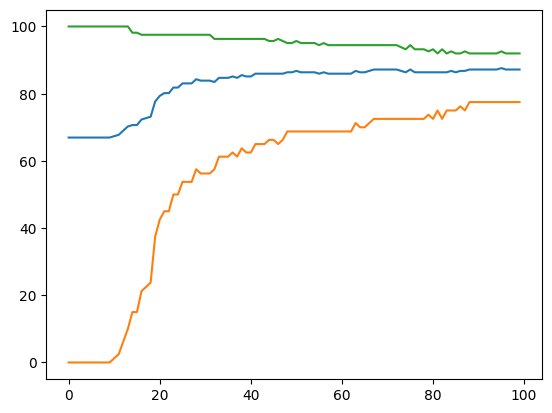

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 1536
model = SimpleLinearModel(input_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracy = []
accuracy_0 = []
accuracy_1 = []
num_epochs = 100
for epoch in range(num_epochs):
    for i, (embeddings, labels) in enumerate(train_loader):
        embeddings, labels = embeddings.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
    # Evaluate on the validation set
    with torch.no_grad():
        embeddings, labels = X_val.to(device), y_val.to(device)
        outputs = model(embeddings).squeeze()
        predicted = (outputs >= 0.5).float()
        total = labels.size(0)
        correct = (predicted == labels.float()).sum().item()
        correct_0 = ((predicted == labels.float()) & (labels.float() == 0)).sum().item()
        correct_1 = ((predicted == labels.float()) & (labels.float() == 1)).sum().item()

        accuracy.append(100 * correct / total)
        accuracy_0.append(100 * correct_0 / (labels.float() == 0).sum().item())
        accuracy_1.append(100 * correct_1 / (labels.float() == 1).sum().item())
plt.plot(accuracy)
plt.plot(accuracy_0)
plt.plot(accuracy_1)
plt.show()

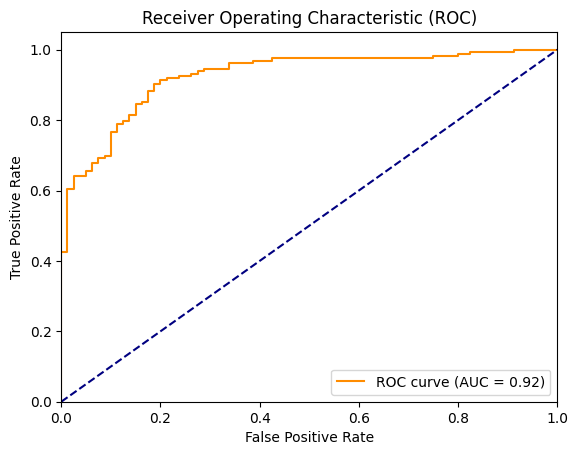

In [98]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Convert the tensors to NumPy arrays
outputs_np = outputs.cpu().detach().numpy()
labels_np = labels.cpu().detach().numpy()

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(labels_np, outputs_np)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


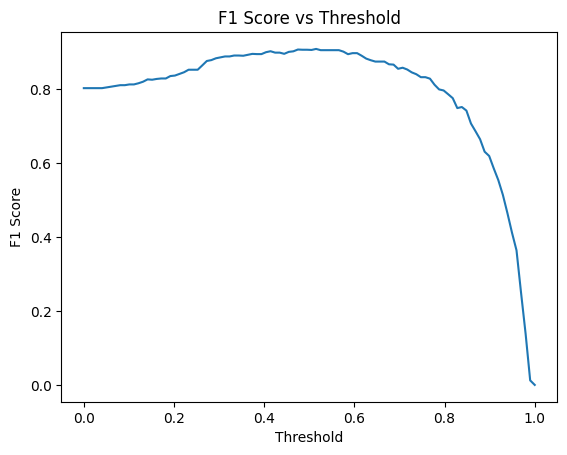

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, num=100)
f1_scores = []

for threshold in thresholds:
    predicted = (outputs_np >= threshold).astype(int)
    f1 = f1_score(labels_np, predicted)
    f1_scores.append(f1)

# Plot the F1 score as a function of the threshold
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()